## Background
Operators offer capping products which limit the amount their customers are charged over a certain period (e.g. daily or weekly). For example:

For a daily capping limit of 5 dollars:

| Day | Amount | Adjusted Amount | Accumulated for the day |
|:----|:-------|:-|:-|
| Trip 1 day 1 | 2 | 2 | 2 |
| Trip 2 day 1 | 2 | 2| 4 | 
| Trip 3 day 1| 2 | 1 | 5 | 
| Trip 1 day 2 | 3 | 3 | 3 | 
| Trip 2 day 2 | 3 | 2 | 5 | 
| Trip 3 day 2 | 3 | 0 | 5 | 

 
## Given:
Given the data dictionary below

#### Products
This table contains the capping product definitions

| Field                              | Description |
|:-----------------------------------|:--|
| id                                 | Unique ID |  
| product_type                       | CAPPING |  
| capping_type                       | DAILY or WEEKLY |  
| created_date                       | Date created |  
| start_date_utc                     | Effective start date |  
| status                             | ACTIVE or INACTIVE |  
| rules_default_limit                | Capping limit amount |  
| rules_max_fare_value               | Fare above this are not included in the capping |  
| rules_transaction_types            | Type of fare |  
| rules_from_time_local              | Time of day in which capping starts effectivity |  
| rules_to_time_local                | Time of day in which capping ends effectivity |  
| rules_weekly_cap_start_day         | If weekly capping, this is the start day (e.g. SUNDAY, MONDAY) |  
| rules_capping_duration_in_minutes  | If product_type is time based, free transfer window |  
| rules_number_of_transfer           | If product_type is time based, number of free transfer |  

#### Trips
This table contains the trips

| Field                       | Description | 
|:----------------------------|:--|
| charge_id                   | Unique Id of the associated charge |  
| trip_id                     | Unique Id of this trip | 
| tap_on_id                   | Tap ON ID provided | 
| tap_on_date                 | Date tapped on |  
| tap_off_id                  | Tap OFF ID provided (if variable) |  
| tap_off_date                | Date tapped off for variable fare |  
| original_amount             | Actual fare |  
| adjusted_amount             | Adjustment after capping was applied |  
| service_type                |  |  
| direction                   |  |  
| fare_type                   | flat, variable or retail|  
| trip_completion             | If trip was completed (if variable and no tap off, this is incomplete) |  

#### Adjustments
This table contains all the adjustments (including zero amount) that were done for a trip. An entry here means the a trip was qualified for a product.

| Field             | Description |
|:------------------|:--|
| product_id        | ID from the product table |  
| trip_id           | Trip ID from the trips table |  
| adjustment_id     | ID related to the group of adjustments. i.e.  |  
| adjustment_amount | Amount deducted from the actual fare |  
| adjustment_type   | Capping type from product table |  
| applied           | True if the fare was adjusted |  
| zone_ids_used     | Zones used in the adjustment |  

For the example earlier, it would have the following sample entries:

##### Product

| id | capping_type | rules_default_limit |
|:- |:-|:-|
| P1| DAILY | 5.0 |
| P2| WEEKLY | 40.0 |

##### Trip

| trip_id | tap_on_date | original_amount | adjusted_amount | trip_completion |
|:-|:-|:-|:-|:-|
| T1 | 2021-07-20 13:00:00.000 | 2.0  | 2.0  | complete  |
| T2 | 2021-07-20 14:00:00.000 | 2.0  | 2.0  | complete  |
| T3 | 2021-07-20 15:00:00.000 | 2.0  | 1.0  | complete  |
| T4 | 2021-07-21 13:00:00.000 | 3.0  | 3.0  | complete  |
| T5 | 2021-07-21 14:00:00.000 | 3.0  | 2.0  | complete  |
| T6 | 2021-07-21 15:00:00.000 | 3.0  | 0.0  | complete  |

###### Adjustments

| product_id| trip_id | adjustment_id | adjustment_amount | applied |
|:-|:-|:-|:-|:-|
| P1 | T1 | AJ1 | 0.0 | false |
| P1 | T2 | AJ1 | 0.0 | false |
| P1 | T3 | AJ1 | 1.0 | true  |
| P1 | T4 | AJ2 | 0.0 | false |
| P1 | T5 | AJ2 | 1.0 | true  |
| P1 | T6 | AJ2 | 3.0 | true  |
| P2 | T1 | AJ3 | 0.0 | false |
| P2 | T2 | AJ3 | 0.0 | false |
| P2 | T3 | AJ3 | 0.0 | false |
| P2 | T4 | AJ4 | 0.0 | false |
| P2 | T5 | AJ4 | 0.0 | false |
| P2 | T6 | AJ4 | 0.0 | false |


## Problem

1. Visualise the growth of the transactions volume (number) and amount which shows before and after the product was applied
2. (Optional) Provide insights about the visualisation. Were the capping product effective? If so, how effective? etc

### Note
You can use any library you like. Just declare it.

In [258]:
# Imports
# NB. You dont have to use pandas.
# pip install pandas
# pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

## Growth in Volume and Amount

### Read the data

In [259]:
# Read the data into dataframes.
products_df = pd.read_csv('products.csv', sep=',') # 6 rows × 14 columns 
trips_df = pd.read_csv('trips.csv', sep=',') # 425425 rows × 13 columns
adjustments_df = pd.read_csv('adjustments.csv', sep=',') # 46100 rows × 7 columns

### Preprocess the Data.

In [260]:
# Left join of trips and adjustments on trip_id
trips_adjustments_df = pd.merge(trips_df, adjustments_df, on='trip_id', how='left')

# df showing trips without adjustments
# no_trips_adjustments_df = trips_adjustments_df[trips_adjustments_df['adjustment_id'].isna()]
# print(no_trips_adjustments_df['adjustment_id'])
# full data of trips, adjustments and products

# Left join of above result and products on product_id
full_df = pd.merge(trips_adjustments_df, products_df, left_on='product_id', right_on='id', how='left')
# full_df.to_csv('full_df.csv')

### Calculate growth of transactions volume and amount

In [261]:
"""
Rows from full_df with product_id are rows where  the products are applied.
Rest are rows without any product.
"""
# Filter rows with and without products
with_product_df = full_df[full_df['product_id'].notna()]
without_product_df = full_df[(full_df['product_id'].isna()) & (full_df['tap_on_date']<'2019-07-17')]

# Calculate the total volume and amount for both cases
with_product_volume = with_product_df['trip_id'].nunique() # 24726
without_product_volume = without_product_df['trip_id'].nunique() # 400699
with_product_amount = with_product_df['adjusted_amount'].sum() # 105045
without_product_amount = without_product_df['original_amount'].sum() #1323939

# Calculate growth
volume_growth = without_product_volume - with_product_volume
amount_growth =  without_product_amount - with_product_amount

In [262]:
"""
From the products table we can observe all the products are effective from 17th July 2019. So, let's see how many trips 
have products attached to them from this date.
"""
# number of transactions with and without products after 2019-07-17(effective date of most of the products)
with_product_after_july17 = full_df[(full_df['product_id'].notna()) & (full_df['tap_on_date'] >= '2019-07-17')]
# with_product_after_july17.info() #46033 
without_product_after_july17 = full_df[(full_df['product_id'].isna()) & (full_df['tap_on_date'] >= '2019-07-17')]
# without_product_after_july17.info() #247096


with_product_after_july17_volume = with_product_after_july17['trip_id'].nunique() #24726
without_product_after_july17_volume = without_product_after_july17['trip_id'].nunique() #247096
with_product_after_july17_amount = with_product_after_july17['adjusted_amount'].sum() # 105045
without_product_after_july17_amount = without_product_after_july17['original_amount'].sum() # 826312

### Total Volume and amount before and after the product was applied

Vizualize the Growth

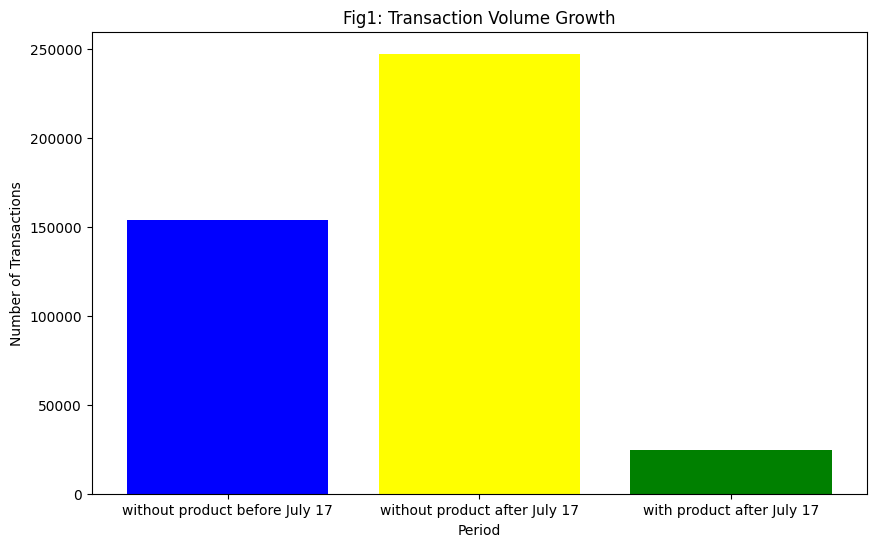

In [263]:
# Plot transaction volume growth
plt.figure(figsize=(10, 6))
plt.bar(['without product before July 17', 'without product after July 17','with product after July 17'], [without_product_volume,
                                                                                      without_product_after_july17_volume,
                                                                                      with_product_after_july17_volume], color=['blue', 'yellow', 'green'])
plt.title('Fig1: Transaction Volume Growth')
plt.xlabel('Period')
plt.ylabel('Number of Transactions')
plt.show()


Transaction Amount

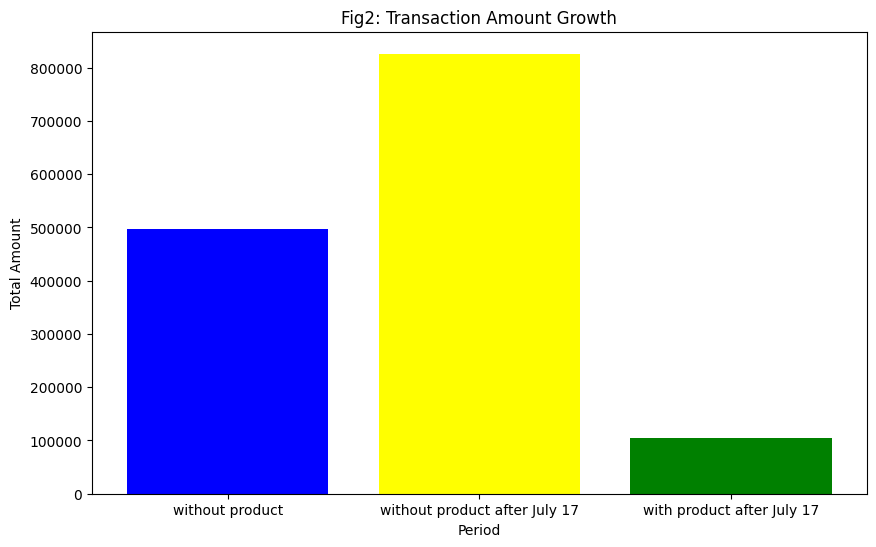

In [264]:
# Plot transaction amount growth
plt.figure(figsize=(10, 6))
plt.bar(['without product', 'without product after July 17','with product after July 17'], [without_product_amount,
                                                                                     without_product_after_july17_amount, 
                                                                                     with_product_after_july17_amount], color=['blue', 'yellow','green'])
plt.title('Fig2: Transaction Amount Growth')
plt.xlabel('Period')
plt.ylabel('Total Amount')
plt.show()

### Growth of Transactions Every Month

In [265]:
with_product_after_july17 = full_df[(full_df['product_id'].notna()) & (full_df['tap_on_date'] >= '2019-07-17')].copy()
with_product_after_july17['tap_on_date'] = pd.to_datetime(with_product_after_july17['tap_on_date'])

# Extract month and year
with_product_after_july17['month_year'] = with_product_after_july17['tap_on_date'].dt.to_period('M')

# Calculate monthly transaction volume and amount
monthly_data = with_product_after_july17.groupby('month_year').agg({
    'trip_id': 'nunique',
    'adjusted_amount': 'sum'
}).reset_index()

# Convert month_year back to datetime for plotting
monthly_data['month_year'] = monthly_data['month_year'].dt.strftime("%b")
monthly_data

,month_year,trip_id,adjusted_amount
0,Jul,182,75.61
1,Aug,703,152.50
2,Sep,23841,104817.22


Montly Transaction Volume after Capping Products are released.

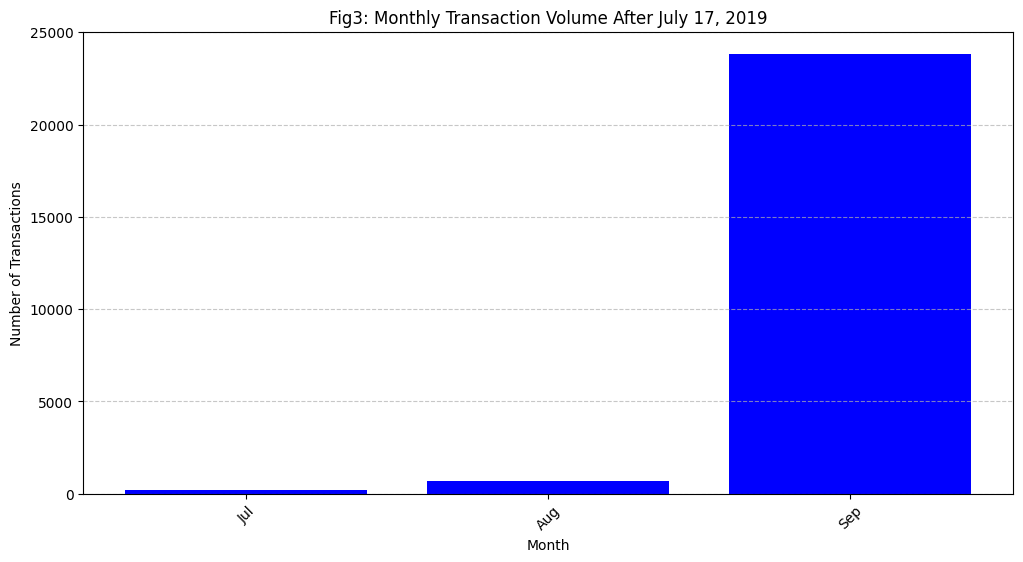

In [266]:
# Plot the transaction volume
plt.figure(figsize=(12, 6))
plt.bar(monthly_data['month_year'], monthly_data['trip_id'], color='blue')
plt.title('Fig3: Monthly Transaction Volume After July 17, 2019')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

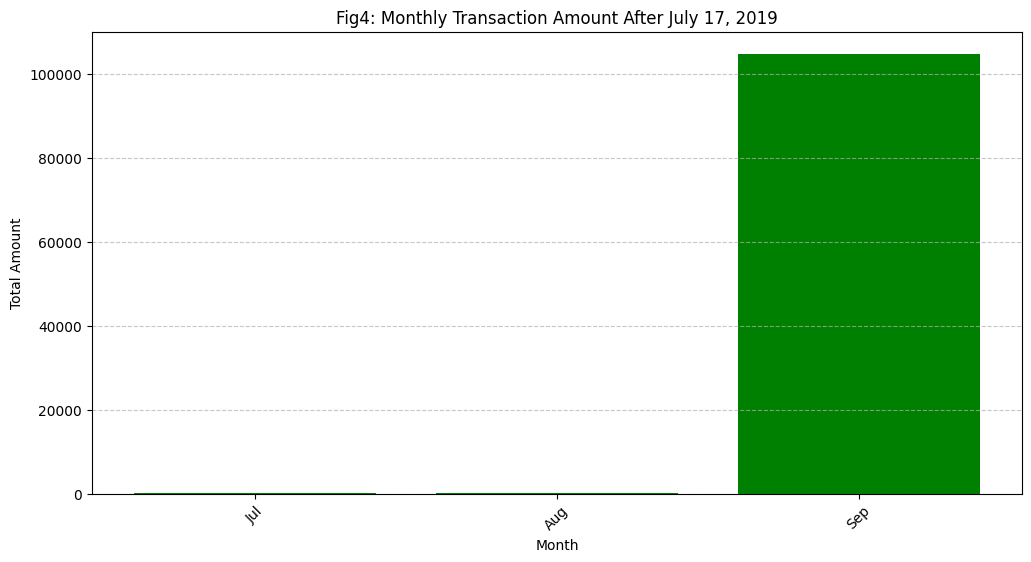

In [267]:
# Plot the transaction amount
plt.figure(figsize=(12, 6))
plt.bar(monthly_data['month_year'], monthly_data['adjusted_amount'], color='green')
plt.title('Fig4: Monthly Transaction Amount After July 17, 2019')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Amount Saved because of capping.

In [268]:
# Amount Saved because of capping.
adjusted_amount = with_product_after_july17['adjusted_amount'].sum() #108700
original_amount = with_product_after_july17['original_amount'].sum() #105045

print("amount_saved :", original_amount-adjusted_amount) #3655

amount_saved : 3655.2799999999843


## Monthly Saving

In [270]:
# Group by month and calculate the sums for adjusted_amount and original_amount
monthly_savings = with_product_after_july17.groupby('month_year').agg({
    'adjusted_amount': 'sum',
    'original_amount': 'sum'
}).reset_index()

# Calculate the amount saved for each month
monthly_savings['amount_saved'] = monthly_savings['original_amount'] - monthly_savings['adjusted_amount']

# Convert month_year to string for better x-axis labels
monthly_savings['month_year_str'] = monthly_savings['month_year'].dt.strftime('%b %Y')

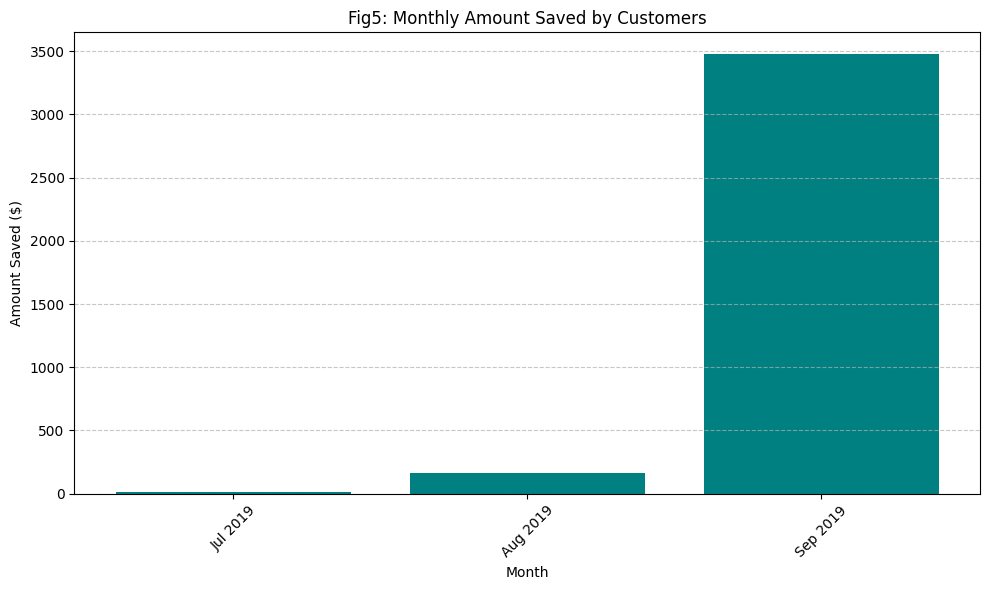

In [271]:
# Plot the monthly savings
plt.figure(figsize=(10, 6))
plt.bar(monthly_savings['month_year_str'], monthly_savings['amount_saved'], color='teal')
plt.title('Fig5: Monthly Amount Saved by Customers')
plt.xlabel('Month')
plt.ylabel('Amount Saved ($)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of x-axis labels
plt.show()

##  Insights about the visualisation

The dataset includes data starting from June 1, 2019. However, the capping products were implemented on July 17, 2019. There are approximately 153,600 unique trips recorded before the capping products were introduced. To evaluate the impact of the capping products, we should focus our analysis on the data starting from the date they became effective.

By analyzing the data from July 17, 2019, we can observe the following statistics:
* Number of unique trips without a cap = 247,096
* Number of unique trips with a cap = 24,726
* Total amount without a cap = 1,323,939
* Total amount with a cap = 105,045

From these statistics, we note that there are **24,726 unique trips where customers used the capping products within the three months (July, August, September)**. This is illustrated in **Figure 1**.

Since the number of transactions without a cap is ten times higher than those with a cap, the total amount spent is also proportionally larger. This is shown in **Figure 2**.

To determine if customers have started using the capping products, we can visualize the number of trips per month where capping was applied. This will help us assess the effectiveness of the capping products.
`
| month_year | trip_id | adjusted_amount |
|:- |:-|:-|
| Jul| 182 | 75.61 |
| Aug| 703 | 152.50 |
| Sep| 23841 | 104817.22 |

From the above table, we can clearly see a **monthly increase in trips** with capped products. This trend is also illustrated in **Figures 3 and 4**.

Additionally, customers have **saved approximately $3,500 over the three-month period**. We can forecast that the amount saved will continue to increase over time, encouraging more customers to use the capping facilities.

# Improvements in data processing

* We used pandas for data processing. As the data size increases, we can make use of **Dask Dataframes** which will help us in processing data parallelly across multiple cores and clusters.
* For efficient reading and storage of the data sets, we can use **parquet file** formats rather than using csvs.